## CT real estate sales via OPM

Let's dive into record-level real estate sales from Connecticut's Office of Policy and Management. It's the first state-wide, record-level data set I've ever seen of property transfesr, so we should be able to determine a lot more than we can get from state- and county-level data from sites like Realtor and Zillow's research data sites.

https://data.ct.gov/Housing-and-Development/Real-Estate-Sales-2001-2016/5mzw-sjtu?category=Housing-and-Development



### Download and preview the data

In [2]:
import pandas as pd

In [4]:
""" This will hold a clean copy of the data we download. Better to put this in its own cell, 
so we don't clear the variable every time we update the function in the next cell.
"""
df_cache = None

In [5]:

def get_df():
    
    """ Download (or load a copy from cache) of the data set. It's big."""
    
    global df_cache
    
    if df_cache is None:
        url = "https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD"
        df_cache = pd.read_csv(url)

    
    return df_cache.copy()

In [79]:
""" Go fetch the data. This will take a while """
df = get_df()

In [80]:
""" Here's how big it is """
df.shape

(815905, 13)

In [81]:
""" Here's the type of each column."""
df.dtypes

ID                   int64
SerialNumber         int64
ListYear             int64
DateRecorded        object
Town                object
Address             object
AssessedValue      float64
SaleAmount         float64
SalesRatio         float64
PropertyType        object
ResidentialType     object
NonUseCode          object
Remarks             object
dtype: object

In [82]:
""" Here's the first few rows """
df.head()

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
0,1,14046,2014,09/29/2015 12:00:00 AM,Andover,US ROUTE 6 M 33 B 36 L 22,10720.0,75000.0,0.142933,Vacant Land,NaN,NaN,NaN
1,2,900035,2009,07/20/2010 12:00:00 AM,Andover,1 DOGWOOD DRIVE,55600.0,99000.0,0.561616,Vacant Land,NaN,NaN,NaN
2,3,14011,2014,01/14/2015 12:00:00 AM,Andover,1 JUROVATY LANE,153100.0,190000.0,0.805789,Residential,Single Family,NaN,NaN
3,4,80009,2008,01/21/2009 12:00:00 AM,Andover,1 ROSE LANE,116600.0,138900.0,0.839453,Residential,Single Family,NaN,NaN
4,5,15006,2015,11/30/2015 12:00:00 AM,Andover,1 ROSE LANE,102900.0,50000.0,2.058000,Residential,Single Family,14 - Foreclosure,PROPERTY WAS OWNED BY THE BANK


### Clean up the datetime column

Let's read the date strings in as actual datetime objects, put the in a new column, and also make a column of those datetimes converted to simple dates, for when we are not interested in the time. Let's also make one that's just the sale month and just the year for easier grouping later.


In [83]:
from datetime import datetime
def fix_date(dtstr):
    
    fmt = "%m/%d/%Y %I:%M:%S %p" 
    
    try:
        return datetime.strptime(dtstr, fmt)
    except Exception as e:
        #print e
        pass
    
def just_date(dt):
    if dt is None:
        return dt
    return dt.date()

def just_ymo(dt):
    if dt is None:
        return dt
    return dt.strftime("%Y-%m")

def just_year(dt):
    if dt is None:
        return dt
    return int(dt.strftime("%Y"))

df["clean_datetime"] = df["DateRecorded"].apply(fix_date)
df["clean_date"] = df["clean_datetime"].apply(just_date)
df["ymo"] = df["clean_datetime"].apply(just_ymo)
df["sale_year"] = df["clean_datetime"].apply(just_year)

## There's one date with a year 9999. Drop that

df = df[df["sale_year"] <  2100 ]

### Clean up the non-use codes

Code that has a null or zero re-use code we'll treat as usable.

But first, we have to clean up the use codes into zero-padded numeric strings, "00", "01"... "25" etc...

As we can see in the next cell, they're not very uniform right now. We have strings like "1" and "01 - Family", which should be the same thing.

In [84]:
df["NonUseCode"].value_counts()

0                                   290379
7                                    33301
25                                   32516
14                                   29817
1                                    15234
8                                    13783
14 - Foreclosure                      9949
25 - Other                            9436
07                                    8233
6                                     7203
28                                    4819
3                                     4377
07 - Change in Property               4305
08                                    4024
01                                    4010
10                                    3697
24                                    2961
15                                    2515
08 - Part Interest                    2359
13                                    2104
18                                    2072
16                                    1981
11                                    1754
01 - Family

In [85]:
def clean_code(codestr):
    
    """ We're going to clean the columns by taking only the first two characters 
    and converting them to zpadded numeric strings."""
    
    if pd.isnull(codestr): return codestr
    return codestr[:2].strip().zfill(2)

clean_code("0")

'00'

In [86]:
df["clean_code"] = df["NonUseCode"].apply(clean_code)

In [87]:
df["clean_code"].value_counts().sort_index()

00    290379
01     20784
02       294
03      5634
04       929
05       151
06      9222
07     45839
08     20166
09       699
10      4448
11      1987
12      1310
13      2170
14     39766
15      3033
16      2198
17      1702
18      2659
19       574
20        10
21       204
22       946
23       262
24      3337
25     41952
26       553
27        89
28      5432
29       661
30       196
31        16
32         2
33         1
34         1
37         2
38         1
48         1
55         1
68         1
73         3
74         1
75         1
88         1
Name: clean_code, dtype: int64

### Looks good, but...

There are some non-use codes greater than 30, but the documentation does not specify any non-use codes that high. Let's just look at those below. They're probably just data entry errors. Since there are so few, we'll just drop them and not worry about it.


In [88]:
df[pd.to_numeric(df["clean_code"], errors="coerce") > 30 ].head()

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks,clean_datetime,clean_date,ymo,sale_year,clean_code
26328,26328,30274,2003,04/30/2004 12:00:00 AM,Bloomfield,26 APRIL WAY,10000.0,309900.0,3.220000,Residential,Single Family,73,NaN,2004-04-30 00:00:00,2004-04-30,2004-04,2004.0,73
45131,45131,42157,2004,05/11/2005 12:00:00 AM,Bridgeport,1944 & E MAIN ST &,160560.0,390000.0,41.169231,Residential,Single Family,37,NaN,2005-05-11 00:00:00,2005-05-11,2005-05,2005.0,37
97751,97751,50550,2005,09/08/2006 12:00:00 AM,Cheshire,20 BRAMBLE WAY,21000.0,484750.0,4.332130,Condo,NaN,74,NaN,2006-09-08 00:00:00,2006-09-08,2006-09,2006.0,74
106765,106766,40182,2004,04/25/2005 12:00:00 AM,Clinton,8 TAYLOR RDG,54900.0,123500.0,44.453441,Vacant Land,NaN,38,NaN,2005-04-25 00:00:00,2005-04-25,2005-04,2005.0,38
149172,149168,30234,2003,08/27/2004 12:00:00 AM,East Haddam,10 MABEL RD,136980.0,310000.0,44.180000,Residential,Single Family,31,NaN,2004-08-27 00:00:00,2004-08-27,2004-08,2004.0,31


### Make a dataframe of sales without non-use codes

Non-use codes signify that for some reason the sale price does not reflect the market value of the property.

In [89]:
df["useable"] = df["clean_code"].apply(lambda x: x == "00" or pd.isnull(x))

In [90]:
""" How many usable records do we have? """
len(df[df["useable"]])

598655

In [91]:
""" Make a usable dataframe """
useable = df[df["useable"]]
print len(useable)

598655


In [92]:
""" Count how many are 00 and how many are NaN """
useable["clean_code"].value_counts(dropna=False)

NaN    308276
00     290379
Name: clean_code, dtype: int64

### Look at property types

In [93]:
useable["PropertyType"].value_counts()

Residential       456074
Condo              96239
Vacant Land        20852
Commercial         18400
Apartments          3297
Industrial          2350
Public Utility        24
10 Mill Forest         5
Name: PropertyType, dtype: int64

### Let's get plotting

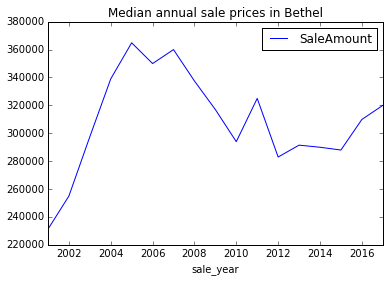

In [94]:
import numpy as np
%matplotlib inline
useable.groupby(["Town","sale_year"]).agg({"SaleAmount":np.median}).loc["Bethel"].plot(
title="Median annual sale prices in Bethel")

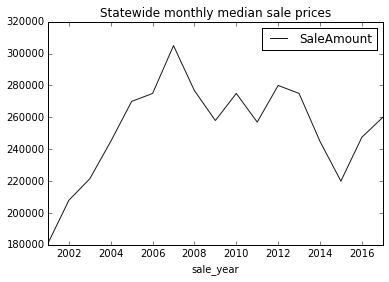

In [173]:
useable[useable["PropertyType"] == "Residential"].groupby(["sale_year"]).agg({"SaleAmount":np.median}).plot(
    title="Statewide monthly median sale prices",
    color=(0.1,0.1,0.1,1)
)

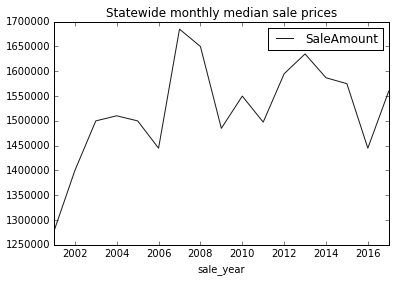

In [207]:
useable[(useable["PropertyType"] == "Residential")
       &(useable["SaleAmount"] > 1000000)].groupby(["sale_year"]).agg({"SaleAmount":np.median}).plot(
    title="Statewide monthly median sale prices",
    color=(0.1,0.1,0.1,1)
)

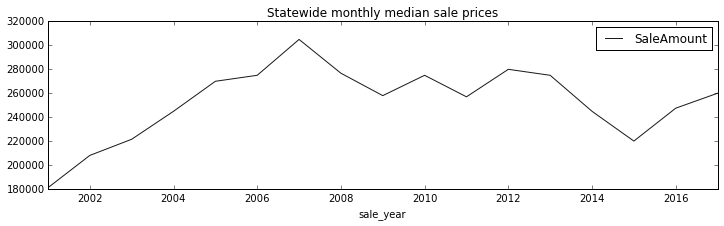

In [199]:
useable[useable["PropertyType"] == "Residential"].groupby(["sale_year"]).agg({"SaleAmount":np.median}).plot(
    title="Statewide monthly median sale prices",
    color=(0.1,0.1,0.1,1),
    figsize=(12,3)
)

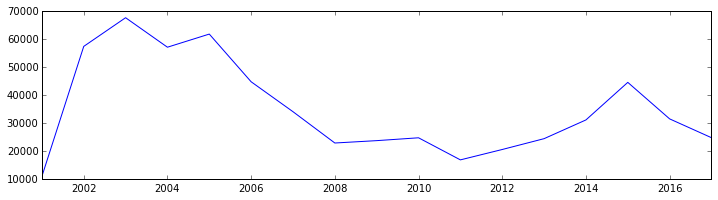

In [198]:
useable["sale_year"].value_counts().sort_index().plot(figsize=(12,3))

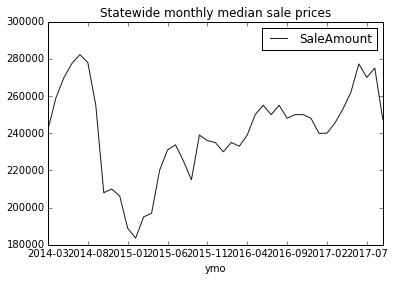

In [183]:
# What happened in 2014? Zoom ....

useable[(useable["PropertyType"] == "Residential")
       &(useable["clean_date"] > datetime(2014,3,1).date())].groupby(["ymo"]).agg({"SaleAmount":np.median}).plot(
    title="Statewide monthly median sale prices",
    color=(0.1,0.1,0.1,1)
)

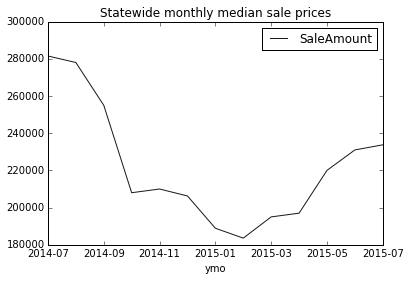

In [187]:
# What happened in 2014? Zoom 2 ....

useable[(useable["PropertyType"] == "Residential")
       &(useable["clean_date"] > datetime(2014,7,1).date())
       &(useable["clean_date"] < datetime(2015,8,1).date())].groupby(["ymo"]).agg({"SaleAmount":np.median}).plot(
    title="Statewide monthly median sale prices",
    color=(0.1,0.1,0.1,1)
)

In [190]:
# Sales volume for worst month since recovery
len(useable[useable["ymo"]=="2015-02"])

2531

In [191]:
useable[useable["ymo"]=="2015-02"]["SaleAmount"].describe()

count    2.445000e+03
mean     3.844504e+05
std      9.570678e+05
min      2.000000e+03
25%      1.085000e+05
50%      1.836740e+05
75%      3.429670e+05
max      2.320000e+07
Name: SaleAmount, dtype: float64

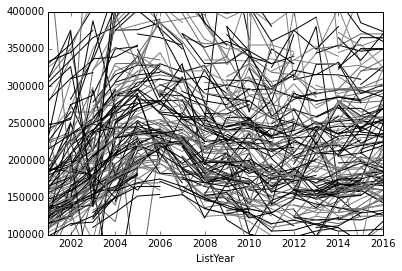

In [98]:
### 
towns = pd.pivot_table(df.groupby(["Town","ListYear"]).agg({"SaleAmount":np.median}).reset_index(),
               columns="ListYear",values="SaleAmount",index="Town")

towns.transpose().plot(color=("0.4","0.","0.","0.5"),
                       legend=False,
                       ylim=(100000,400000))


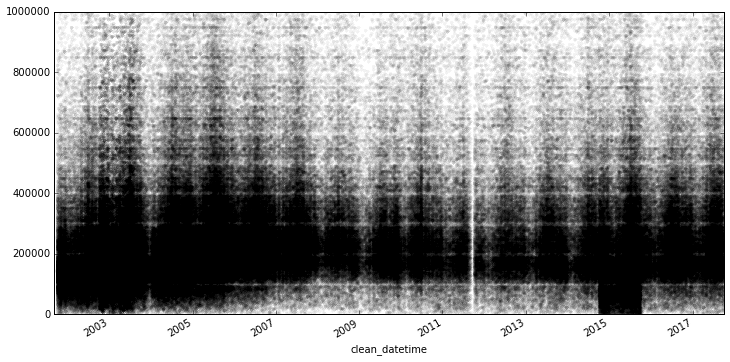

In [135]:
useable.plot(x="clean_datetime",y="SaleAmount",
             style=".",
             ylim=(0,1000000), 
             color=(0,0,0,0.05), legend=None, 
             figsize=(12,6)
            )

In [161]:
# """ No one sells a house for an even multiple of 100,000. No one. """

useable[(useable["SaleAmount"] % 100000 == 0) & (useable["SaleAmount"] < 1000000)]

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks,clean_datetime,clean_date,ymo,sale_year,clean_code,useable
700589,700590,20728,2002,07/14/2003 12:00:00 AM,Wallingford,8 HALL RD,116500.0,0.0,0.0,Residential,Single Family,0,NaN,2003-07-14 00:00:00,2003-07-14,2003-07,2003.0,00,True


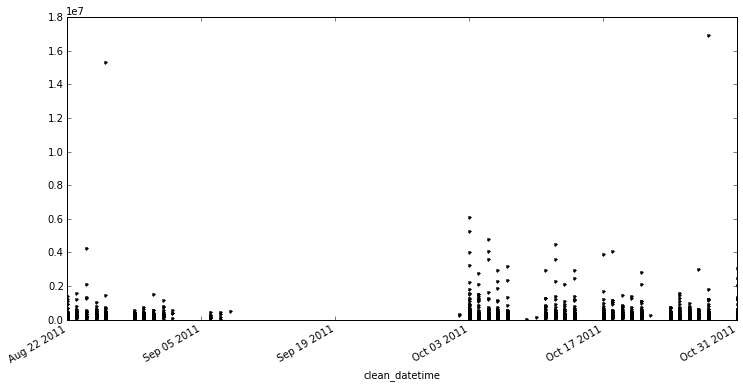

In [159]:
useable[(useable["clean_date"] > datetime(2011,8,20).date())
       & (useable["clean_date"] < datetime(2011,11,1).date())].plot(x="clean_datetime",y="SaleAmount",
             style=".",
             color=(0,0,0,1), legend=None, 
             figsize=(12,6)
            )

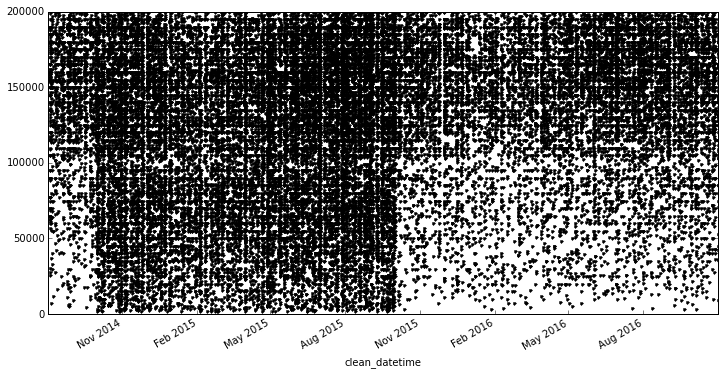

In [220]:
""" Why all these < 100K sales during the Nov 2014 and Nov 2015? """

useable[(useable["clean_date"] > datetime(2014,8,1).date())
       & (useable["clean_date"] < datetime(2016,11,1).date())].plot(x="clean_datetime",y="SaleAmount",
             style=".",
             color=(0,0,0,1), legend=None, 
             figsize=(12,6),
                                                                    ylim=(0,200000)
            )

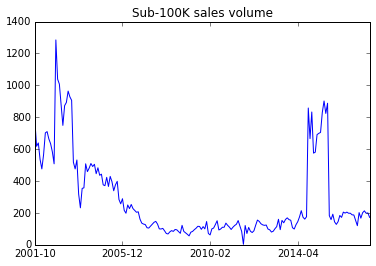

In [224]:
""" Here's a look at that phenom another way"""
useable[useable["SaleAmount"] < 100000]["ymo"].value_counts().sort_index().plot(
    title="Sub-100K sales volume"
)

In [228]:
""" Let's break down the property types selling for < 100K """
useable[useable["SaleAmount"] < 100000]["PropertyType"].value_counts()

Residential       23565
Condo             18903
Vacant Land        9961
Commercial         1872
Industrial          180
Apartments          156
Public Utility       10
10 Mill Forest        1
Name: PropertyType, dtype: int64

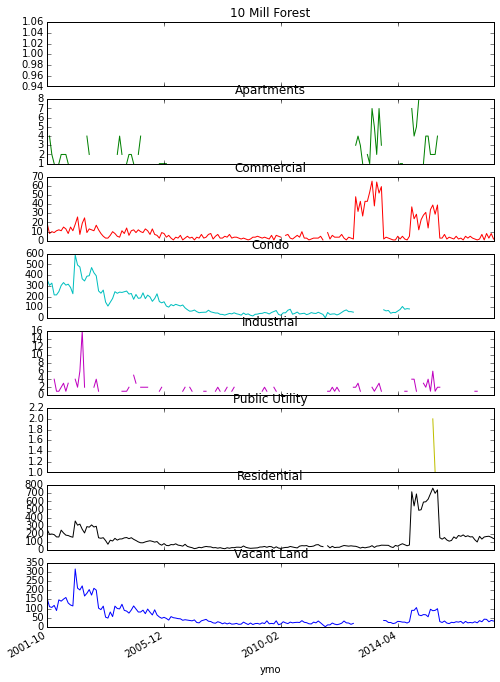

In [281]:
""" Let's see if one type of property spiked """
import numpy as np

def volume_timelines():
    tmpdf = useable[useable["SaleAmount"] < 100000].groupby(["PropertyType","ymo"]).agg({"SaleAmount":np.size}).reset_index()
    tmpdf.columns = ["PropertyType","ymo","count"]
    tmpdf

    plots = pd.pivot_table(
        tmpdf,
        index="PropertyType",
        columns="ymo",
        values="count"
    ).transpose().plot(subplots=True,legend=False,
                      figsize=(8,12))
    
    for sub in plots:
        sub.set_title(sub.lines[0].get_label())
    
volume_timelines()

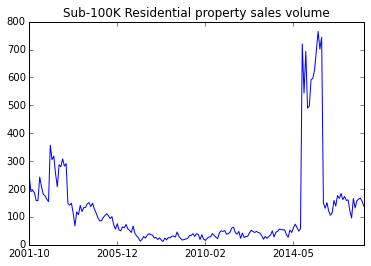

In [282]:
useable[(useable["PropertyType"] == "Residential")
       &(useable["SaleAmount"] < 100000)]["ymo"].value_counts().sort_index().plot(
    title="Sub-100K Residential property sales volume"
)

In [283]:
cheap = useable[(useable["ResidentialType"] == "Single Family")
                &(useable["SaleAmount"] < 100000)]
len(cheap)

21389

In [291]:
(cheap["Town"].value_counts() / len(cheap)).head()

Waterbury        0.100005
Bridgeport       0.057787
Norwich          0.043153
East Hartford    0.033475
New Britain      0.031418
Name: Town, dtype: float64

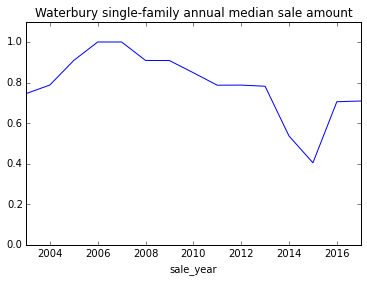

In [316]:
def town_chart(town):

    tmpdf = useable[(useable["ResidentialType"] == "Single Family")
           &(useable["Town"] == town)].groupby("sale_year").agg({"SaleAmount":np.median})\
    .sort_index()
    
    ymax = tmpdf["SaleAmount"].max()
    
    tmpdf["SaleAmount"] = tmpdf["SaleAmount"] / ymax
    
    tmpdf.plot(
        title=town + " single-family annual median sale amount",
        legend=False,
        ylim=(0,1.1)
    )
    
town_chart("Waterbury")

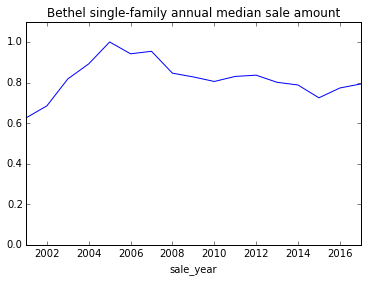

In [317]:
town_chart("Bethel")

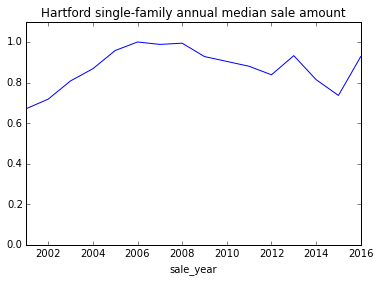

In [318]:
town_chart("Hartford")

In [319]:
import matplotlib.pyplot as plt
def make_all_town_charts():
    for t in useable["Town"].unique():
        town_chart(t)
        plt.gcf().savefig("output/" + t + ".png")
        plt.close()
        
make_all_town_charts()

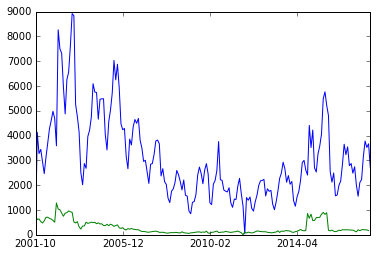

In [304]:
""" Compare sub 100K sales to all sales"""

def sales_volume_combo():
    
    all_sales = useable["ymo"].value_counts().sort_index()
    sub_100k = useable[(useable["SaleAmount"] < 100000)]["ymo"].value_counts().sort_index()
    
    ax = all_sales.plot()
    
    sub_100k.plot(ax=ax)
    
sales_volume_combo()
    

In [ ]:
def recovery_table():
    
    ret = towns.copy()
    
    for y in range(2001,2017):
        if y == 2007: continue
        ret[y] = ret[y] / ret[2007]
    ret[2007] = 1
    return ret



In [ ]:
rec = recovery_table()
len(rec[rec[2016] > 1.1])

In [ ]:
len(rec[rec[2016] < 0.9])

In [ ]:
rec[2016].hist()

In [ ]:
rec[2016].describe()

In [ ]:
rec.transpose().plot(
    color=("0","0","0","0.5"),
    legend=False
e)
